In [1]:
import latentvelo as ltv
import numpy as np
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt

Global seed set to 0


# Read data from scvelo package

In [2]:
adata = scv.datasets.gastrulation_erythroid()

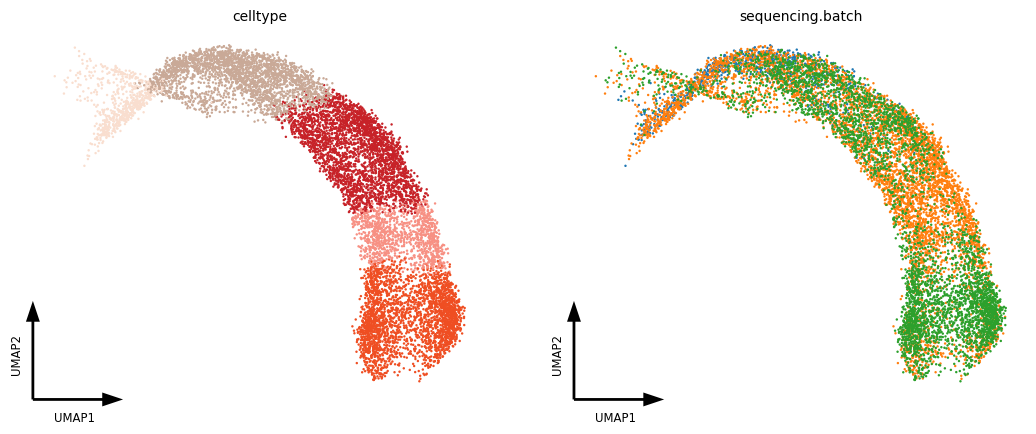

In [3]:
scv.pl.umap(adata, color=['celltype', 'sequencing.batch'], frameon='artist')

# Setup data and train model

In [4]:
scv.pp.filter_genes(adata, min_shared_counts=20)
ltv.utils.standard_clean_recipe(adata, batch_key='sequencing.batch')

Filtered out 47456 genes that are detected 20 counts (shared).
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:19) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [5]:
model = ltv.models.VAE(observed=2000, latent_dim=20, zr_dim=1, h_dim=1,
                      batch_correction=True, batches=3)

In [6]:
epochs, val_ae, val_traj = ltv.train(model, adata, batch_size = 100,
                                      epochs=25, name='mouse_erythroid_parameters', grad_clip=100)

Warning, folder already exists. This may overwrite a previous fit.
487 velocity genes used
epoch 0, full loss 107.578, val loss 145.965, recon MSE 2.042, traj MSE 3.133, corr reg -3.024
epoch 1, full loss -257.413, val loss -236.612, recon MSE 1.018, traj MSE 2.835, corr reg -2.749
epoch 2, full loss -405.031, val loss -489.083, recon MSE 0.937, traj MSE 2.550, corr reg -2.863
epoch 3, full loss -488.088, val loss -617.556, recon MSE 0.739, traj MSE 2.492, corr reg -2.314
epoch 4, full loss -532.069, val loss -707.577, recon MSE 0.706, traj MSE 2.442, corr reg -2.122
epoch 5, full loss -537.549, val loss -783.129, recon MSE 0.690, traj MSE 2.503, corr reg -1.610
epoch 6, full loss -525.944, val loss -833.912, recon MSE 0.575, traj MSE 2.571, corr reg -1.727
epoch 7, full loss -503.401, val loss -871.980, recon MSE 0.599, traj MSE 2.529, corr reg -1.183
epoch 8, full loss -479.109, val loss -890.581, recon MSE 0.609, traj MSE 2.472, corr reg -1.258
epoch 9, full loss -492.569, val loss 

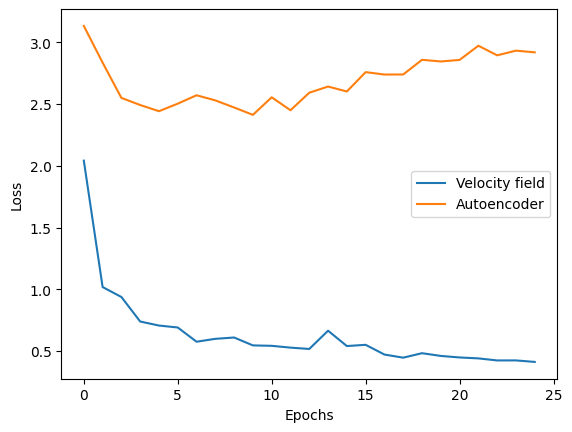

In [7]:
ltv.plot_history(epochs, val_ae, val_traj)
plt.show()

# Compute and plot velocity on UMAP

In [8]:
latent_adata, adata = ltv.output_results(model, adata, gene_velocity=True)

In [9]:
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')

computing velocity graph (using 1/16 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:01) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


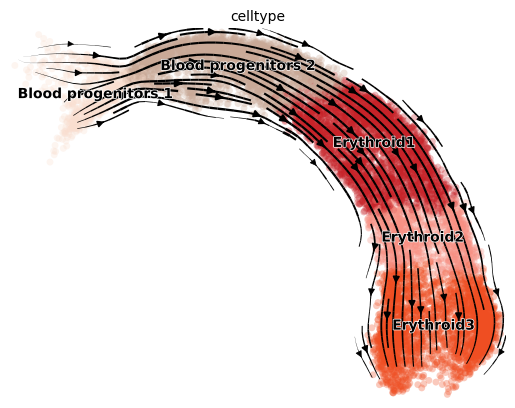

In [10]:
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', color='celltype')

# Compute CBDir transition scores

In [11]:
erythroid_edges = [
    ('Blood progenitors 1', 'Blood progenitors 2'), 
    ('Blood progenitors 2', 'Erythroid1'),
    ('Erythroid1', 'Erythroid2'), 
    ('Erythroid2', 'Erythroid3')]

In [12]:
scv.tl.velocity_embedding(latent_adata, vkey='spliced_velocity', basis='pca')
erythroid_pca = ltv.ev.cross_boundary_correctness(latent_adata,
                                  'celltype', 'spliced_velocity_pca', erythroid_edges, x_emb='X_pca', 
                                                  majority_vote=True, return_raw=True)

computing velocity embedding
    finished (0:00:03) --> added
    'spliced_velocity_pca', embedded velocity vectors (adata.obsm)


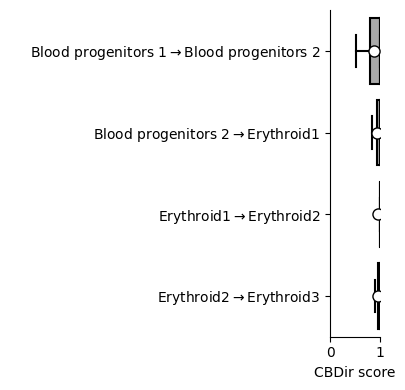

In [13]:
ax=ltv.pl.transition_scores(erythroid_pca, raw=True)
ax.set(xlim=(0,1))
plt.show()

# Analyze MuRK genes

Smim1, Hba-x, and Hbb-bh1 are the top predicted MuRK genes.

In [14]:
adata.var.iloc[np.argsort(-1*adata.var['R2'])]['MURK_gene'][:5]

index
Smim1       True
Hba-x       True
Rbpms      False
Hbb-bh1     True
Cnn3       False
Name: MURK_gene, dtype: bool

In [15]:
from scipy.interpolate import griddata
from scipy.stats import gaussian_kde

plt.rcParams.update({'font.size': 18})

def scatter_stream(adata, gene, cluster_key = None, save=False, name_pre = ''):

    s_gene = np.array(adata[:,adata.var.index==gene].layers['spliced'])[:,0] #[:,None]
    u_gene = np.array(adata[:,adata.var.index==gene].layers['unspliced'])[:,0] #[:,None]
    
    adata.obsm['X_'+gene] = np.concatenate((s_gene[:,None], u_gene[:,None]), axis=-1)
    
    vs_gene = np.array(adata[:,adata.var.index==gene].layers['velo_s'])[:,0]
    vu_gene = np.array(adata[:,adata.var.index==gene].layers['velo_u'])[:,0]
    
    
    x = np.linspace(s_gene.min()*1.1, s_gene.max()*0.9, 250)
    y = np.linspace(u_gene.min()*1.1, u_gene.max()*0.9, 250)

    S, U = np.meshgrid(x, y)# s_gene, u_gene)
    
    VS = griddata((s_gene, u_gene), vs_gene, (S, U), method='linear')
    VU = griddata((s_gene, u_gene), vu_gene, (S, U), method='linear')
    
    kernel = gaussian_kde(adata.obsm['X_'+gene][(s_gene > 0) & (u_gene > 0)].T)
    
    positions = np.vstack([S.ravel(), U.ravel()])
    density = np.reshape(kernel(positions).T, S.shape)

    VS[density< 1.] = np.nan
    VU[density< 1.] = np.nan
    
    fig,ax=plt.subplots()
    plt.streamplot(S, U, VS, VU, color='k', linewidth=1.5, arrowsize=1.5)
    
    sc.pl.scatter(adata, basis=gene, color=cluster_key, ax=ax, title = gene, 
                  frameon=True, legend_loc='none', show=False, size=100, legend_fontsize=18)
    plt.xlabel('spliced')
    plt.ylabel('unspliced')
    if save:
        plt.savefig('figures/' + name_pre + str(gene) + '.pdf')
    else:
        return fig

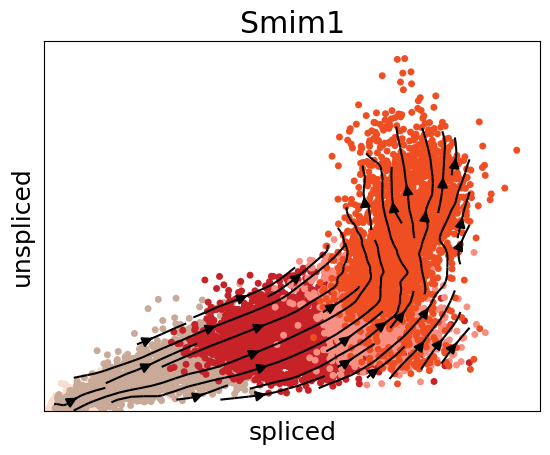

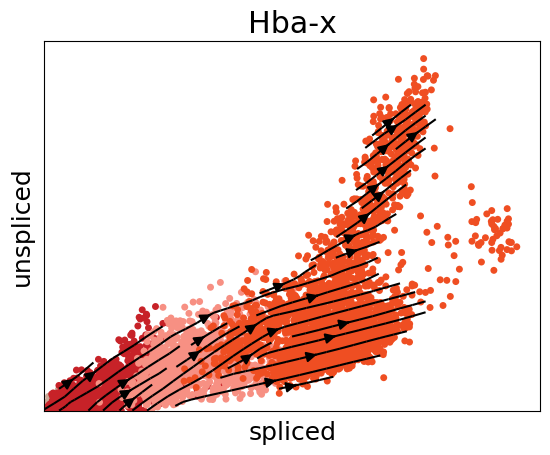

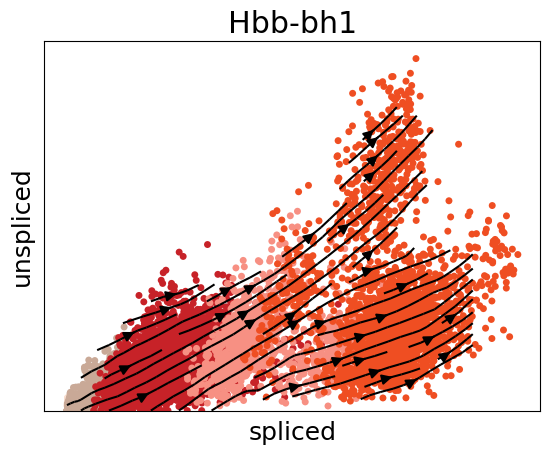

In [16]:
scatter_stream(adata, 'Smim1', cluster_key='celltype')
plt.show()
scatter_stream(adata, 'Hba-x', cluster_key='celltype')
plt.show()
scatter_stream(adata, 'Hbb-bh1', cluster_key='celltype')
plt.show()

Weird behavior of Hbb-bh1 comes from the sequencing batches:

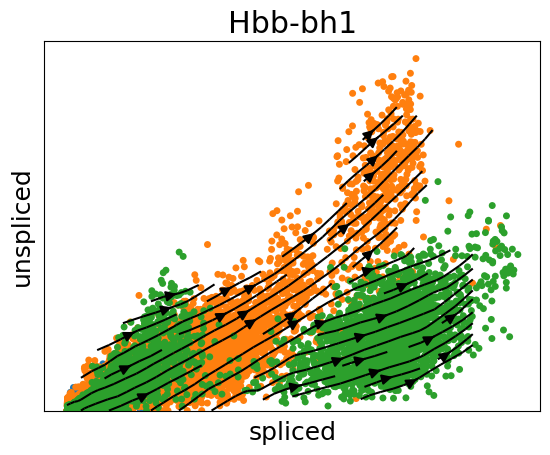

In [17]:
scatter_stream(adata, 'Hbb-bh1', cluster_key='sequencing.batch')
plt.show()